# Planetary Computer

import Tag from '@site/src/components/Tag'

Fused interfaces <Tag color="#3399ff">Microsoft Planetary Computer</Tag> through the Python `pystac_client` library. This example shows how to load data from [Planetary Computer](https://planetarycomputer.microsoft.com/) within your Fused UDFs.

In [ ]:
# !pip install fused odc-stac numba xarray-spatial planetary-computer 'odc-stac[botocore]'

In [20]:
import fused


@fused.udf
def udf(bbox, time_of_interest="2023-11-01/2023-12-30"):

    import odc.stac
    import planetary_computer
    import pystac_client

    utils = fused.load(
        "https://github.com/fusedio/udfs/tree/f928ee1/public/common/"
    ).utils

    red_band = "B04"
    nir_band = "B08"
    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1",
        modifier=planetary_computer.sign_inplace,
    )

    items = catalog.search(
        collections=["sentinel-2-l2a"],
        bbox=bbox.total_bounds,
        datetime=time_of_interest,
        query={"eo:cloud_cover": {"lt": 10}},
    ).item_collection()

    print(f"Returned {len(items)} Items")
    resolution = int(5 * 2 ** (15 - bbox.z[0]))
    print(f"{resolution=}")
    ds = odc.stac.load(
        items,
        crs="EPSG:3857",
        bands=[nir_band, red_band],
        resolution=resolution,
        bbox=bbox.total_bounds,
    ).astype(float)
    ndvi = (ds[nir_band] - ds[red_band]) / (ds[nir_band] + ds[red_band])
    print(ndvi.shape)
    arr = ndvi.max(dim="time")
    return utils.arr_to_plasma(arr.values, min_max=(0, 0.8), reverse=False)


arr = fused.run(udf=udf, x=327, y=792, z=11, engine="local")

Returned 2 Items
resolution=80
(2, 245, 246)


In [21]:
arr

array([[[ 12,  12,  12, ...,  12,  12,  12],
        [ 12,  12,  12, ...,  12,  12,  12],
        [ 12,  12,  12, ...,  12,  12,  12],
        ...,
        [ 12,  12,  12, ..., 234,  69,  63],
        [ 12,  12,  12, ...,  63,  79,  12],
        [ 12,  12,  12, ...,  81, 151,  49]],

       [[  7,   7,   7, ...,   7,   7,   7],
        [  7,   7,   7, ...,   7,   7,   7],
        [  7,   7,   7, ...,   7,   7,   7],
        ...,
        [  7,   7,   7, ..., 115,   3,   3],
        [  7,   7,   7, ...,   3,   2,   7],
        [  7,   7,   7, ...,   1,  19,   4]],

       [[134, 134, 134, ..., 134, 134, 134],
        [134, 134, 134, ..., 134, 134, 134],
        [134, 134, 134, ..., 134, 134, 134],
        ...,
        [134, 134, 134, ...,  86, 158, 156],
        [134, 134, 134, ..., 156, 162, 134],
        [134, 134, 134, ..., 162, 160, 150]]], dtype=uint8)

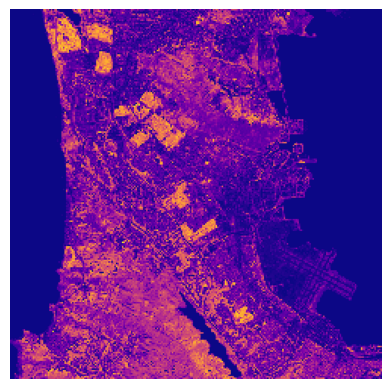

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Transpose the axes to match image format
image_array = np.transpose(arr, (1, 2, 0))

# Display the image
plt.imshow(image_array)
plt.axis("off")  # Optional: turn off axis
plt.show()